# Notebook version of QAOA

In [1]:
# Quantum Approximate Optimization Algorithm using Gate-based QC

# This Notebook acts as a host for Q# to implement Quantum Approximate Optimization Algorithm (QAOA) on a gate-based Quantum Computing model.

# Importing required libraries

# General imports
import time
from numpy import pi
import numpy as np
import matplotlib.pyplot as plt

# Libraries for Model Formulation
from docplex.mp.model import Model
from scipy.optimize import minimize
from collections import Counter

import qsharp

# Qiskit Imports
from qiskit_optimization.converters import QuadraticProgramToQubo
from qiskit.visualization import plot_histogram
from qiskit_optimization.translators import from_docplex_mp

# Library for circuit simulation
import pennylane as qml


In [2]:
# Function to sort the count dictionary.
def find_most_common_solutions(input_dict, n):
    sorted_keys = sorted(input_dict, key=input_dict.get, reverse=True)
    return sorted_keys[:n]


# Building the model and its Cost Function
 
# We are using ***docplex*** to build the model and calculate $Q$ and $c$.

def build_qubo(arr: list):

    n = len(arr)
    c = sum(arr)
    # Building the model and its QUBO formulation.
    model = Model()
    x = model.binary_var_list(n)

    Q =  (c - 2*sum(arr[i]*x[i] for i in range(n)))**2
    model.minimize(Q)   

    problem = from_docplex_mp(model)

    converter = QuadraticProgramToQubo()
    qubo = converter.convert(problem)
    # print(qubo)

    quadratics = qubo.objective.quadratic.coefficients
    linears = qubo.objective.linear.coefficients

    return quadratics, linears, qubo


In [3]:
%%qsharp
open Microsoft.Quantum.Convert;
/// # Description
/// This is a program for simulating the QAOA circuit. 
namespace qaoa_note {

    open Microsoft.Quantum.Arrays;
    open Microsoft.Quantum.Diagnostics;
    open Microsoft.Quantum.Measurement;

    // Function for getting flat index
    operation flat_index(n: Int, i: Int, j: Int): Int{
        return n*i +j
    }

    operation cost_unitary(qubits: Qubit[], gamma: Double, quadratics: Double[], linears: Double[]): Unit{
        
        let n_qubits = Length(linears);
        mutable quad_sum : Double = 0.0;
        // RZ Gates
        for qubit in 0..n_qubits-1{
            set quad_sum = 0.0;
            for quad_qubit in 0..n_qubits-1{
                set quad_sum += quadratics[flat_index(n_qubits,qubit,quad_qubit)];
            }
            Rz(0.5 * (linears[qubit] + quad_sum) * gamma, qubits[qubit])
        }
        // RZZ Gates
        for i in 0..n_qubits-1{
            for j in i+1..n_qubits-1{
                Rzz(0.25 * quadratics[flat_index(n_qubits,i,j)] * gamma, qubits[i], qubits[j])
            }
        }
    }

    operation mixer_unitary(qubits: Qubit[], beta: Double) : Unit{
        for qubit in qubits{
            Rx(2.0 * beta,qubit);
        }
    }

    operation circuit(NQubits: Int, Layers: Int, gammas: Double[], betas: Double[], quadratics: Double[], linears: Double[]) : Int {
        use q = Qubit[NQubits]; 
        mutable integer_result = 0;

        ApplyToEachA(H,q);

        for i in 0..Layers-1{

            mixer_unitary(q, betas[i]);
            cost_unitary(q, gammas[i], quadratics, linears)
            
        }

        return MeasureInteger(q);

    }
}


In [4]:
def interger_to_counts(n,result):
    counts = {}
    for i in range(2**n):
        counts[np.binary_repr(i,width=n)] = 0
    for integer in result:
        counts[np.binary_repr(integer,width=n)] += 1
    return counts

def arr_to_str(a):
    """
    Converts a given array to a string representation.

    Args:
        a (list): The array to be converted.

    Returns:
        str: The string representation of the array.

    Example:
        >>> arr_to_str([1, 2, 3])
        '[1, 2, 3]'
    """
    string =''
    for i in a:
        string += str(i) + ","
    return '[' + string[:-1] + ']'

In [5]:
# ## Creating the QAOA circuit and layers.
# 
# I'm using ***Pennylane*** to handle the circuit simulations. I have created functions to generate the QAOA circuit given $Q$ and $c$.

func_call = 0
theta = []
cost = []

def callback_func(x):
    theta.append(x)

def qaoa_NPP(arr,layers:int):
    
    quadratics, linears, qubo = build_qubo(arr)
    num_qubits = len(arr)

    quadratics = quadratics.toarray().flatten()
    linears = linears.toarray()

    # Initial guess
    init_gamma = np.array([pi/1.5]*layers)
    init_beta = np.array([pi/4]*layers)
    initial_guess = np.concatenate((init_gamma, init_beta))
    
    def expectation_value(theta):
        global func_call 
        func_call = func_call + 1
        print(f'Function call: {func_call}')
        middle = int(len(theta)/2)
        gammas = theta[:middle]
        betas = theta[middle:]

        input_str = f"{num_qubits},{layers},{arr_to_str(gammas)},{arr_to_str(betas)},{arr_to_str(quadratics)},{arr_to_str(linears[0])}"

        int_results = qsharp.run(f"qaoa_note.circuit({input_str})",shots=100)
        counts = interger_to_counts(num_qubits,int_results)

        best_sol = max(counts, key=counts.get) # type: ignore
        exp =  qubo.objective.evaluate(np.array(list(best_sol), dtype='int'))
        cost.append(exp)
        return exp

    # Minimization of the objective function.
    start_time = time.time()
    res = minimize(expectation_value, initial_guess, method='COBYLA',callback=callback_func)
    # res = minimize(expectation_value, initial_guess, method='CG')
    end_time = time.time()
    elapsed_time = end_time - start_time

    print(f'Elapsed time for QAOA: {elapsed_time} seconds')

    middle = int(len(res.x)/2)
    prime_gammas = res.x[:middle]
    prime_betas = res.x[middle:]

    input_str = f"{num_qubits},{layers},{arr_to_str(prime_gammas)},{arr_to_str(prime_betas)},{arr_to_str(quadratics)},{arr_to_str(linears[0])}"

    results = qsharp.run(f"qaoa_note.circuit({input_str})",shots=100)
    
    counts = interger_to_counts(num_qubits,results)
    
    return find_most_common_solutions(counts, 3)

In [6]:
test_array = [5,1,6,1]

layers = 3

result_state = qaoa_NPP(test_array,layers)

print(f'\n\nQAOA Solution for {test_array} with {layers} layers is: \n\n {result_state}')

Function call: 1
Function call: 2
Function call: 3
Function call: 4
Function call: 5
Function call: 6
Function call: 7
Function call: 8
Function call: 9
Function call: 10
Function call: 11
Function call: 12
Function call: 13
Function call: 14
Function call: 15
Function call: 16
Function call: 17
Function call: 18
Function call: 19
Function call: 20
Function call: 21
Function call: 22
Function call: 23
Function call: 24
Function call: 25
Function call: 26
Function call: 27
Function call: 28
Function call: 29
Function call: 30
Function call: 31
Function call: 32
Function call: 33
Function call: 34
Function call: 35
Function call: 36
Function call: 37
Function call: 38
Function call: 39
Function call: 40
Function call: 41
Function call: 42
Function call: 43
Function call: 44
Function call: 45
Function call: 46
Function call: 47
Function call: 48
Function call: 49
Function call: 50
Function call: 51
Function call: 52
Elapsed time for QAOA: 63.32979774475098 seconds
['1010', '1001', '0111']

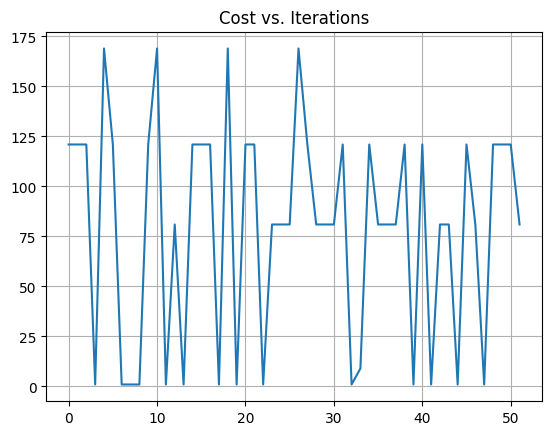

In [7]:
# Cost vs. Iterations
plt.plot(range(len(cost)),cost)
plt.grid()
plt.title('Cost vs. Iterations')
plt.show()

## Using the Resourse Estimator

In [8]:
test_array = [1,2,4]

n = len(test_array)
layers = 3

quadratics, linears, qubo = build_qubo(test_array)
quadratics = quadratics.toarray().flatten()
linears = linears.toarray()

gammas = np.random.rand(layers)
betas = np.random.rand(layers)

input_str = f"{n},{layers},{arr_to_str(gammas)},{arr_to_str(betas)},{arr_to_str(quadratics)},{arr_to_str(linears[0])}"


result = qsharp.estimate(f"qaoa_note.circuit({input_str})", params={"errorBudget": 0.01, "qubitParams": {"name": "qubit_maj_ns_e6"}, "qecScheme": {"name": "floquet_code"}, "constraints": {"logicalDepthFactor": 4}})

In [9]:
result

Runtime,810 microsecs,"Total runtime This is a runtime estimate for the execution time of the algorithm. In general, the execution time corresponds to the duration of one logical cycle (900 nanosecs) multiplied by the 225 logical cycles to run the algorithm. If however the duration of a single T factory (here: 14,100 nanosecs) is larger than the algorithm runtime, we extend the number of logical cycles artificially in order to exceed the runtime of a single T factory."
rQOPS,13.33M,"Reliable quantum operations per second The value is computed as the number of logical qubits after layout (12) (with a logical error rate of 3.09e-7) multiplied by the clock frequency (1,111,111.11), which is the number of logical cycles per second."
Physical qubits,7.90k,"Number of physical qubits This value represents the total number of physical qubits, which is the sum of 624 physical qubits to implement the algorithm logic, and 7,280 physical qubits to execute the T factories that are responsible to produce the T states that are consumed by the algorithm."
Logical algorithmic qubits,12,"Number of logical qubits for the algorithm after layout Laying out the logical qubits in the presence of nearest-neighbor constraints requires additional logical qubits. In particular, to layout the $Q_{\rm alg} = 3$ logical qubits in the input algorithm, we require in total $2 \cdot Q_{\rm alg} + \lceil \sqrt{8 \cdot Q_{\rm alg}}\rceil + 1 = 12$ logical qubits."
Algorithmic depth,225,"Number of logical cycles for the algorithm To execute the algorithm using Parallel Synthesis Sequential Pauli Computation (PSSPC), operations are scheduled in terms of multi-qubit Pauli measurements, for which assume an execution time of one logical cycle. Based on the input algorithm, we require one multi-qubit measurement for the 3 single-qubit measurements, the 27 arbitrary single-qubit rotations, and the 0 T gates, three multi-qubit measurements for each of the 0 CCZ and 0 CCiX gates in the input program, as well as 13 multi-qubit measurements for each of the 15 non-Clifford layers in which there is at least one single-qubit rotation with an arbitrary angle rotation."
Logical depth,900,"Number of logical cycles performed This number is usually equal to the logical depth of the algorithm, which is 225. However, in the case in which a single T factory is slower than the execution time of the algorithm, we adjust the logical cycle depth to exceed the T factory's execution time."
Clock frequency,1.11M,Number of logical cycles per second This is the number of logical cycles that can be performed within one second. The logical cycle time is 901 nanosecs.
Number of T states,351,"Number of T states consumed by the algorithm To execute the algorithm, we require one T state for each of the 0 T gates, four T states for each of the 0 CCZ and 0 CCiX gates, as well as 13 for each of the 27 single-qubit rotation gates with arbitrary angle rotation."
Number of T factories,7,"Number of T factories capable of producing the demanded 351 T states during the algorithm's runtime The total number of T factories 7 that are executed in parallel is computed as $\left\lceil\dfrac{\text{T states}\cdot\text{T factory duration}}{\text{T states per T factory}\cdot\text{algorithm runtime}}\right\rceil = \left\lceil\dfrac{351 \cdot 14,100\;\text{ns}}{1 \cdot 810,000\;\text{ns}}\right\rceil$"
Number of T factory invocations,51,"Number of times all T factories are invoked In order to prepare the 351 T states, the 7 copies of the T factory are repeatedly invoked 51 times."
Physical algorithmic qubits,624,Number of physical qubits for the algorithm after layout The 624 are the product of the 12 logical qubits after layout and the 52 physical qubits that encode a single logical qubit.
